# Clasificación binaria simple

### Paula Juliana Parra Osorio

## Cargue de librerías necesarias

In [1]:
using Pkg
using DataFrames
using CSV
using Plots
using GLM
using StatsBase
using Lathe
using MLBase
using ClassImbalance
using ROCAnalysis
using Lathe.preprocess: TrainTestSplit
using LIBSVM
using DecisionTree
using ScikitLearn
using PyCall
using Printf

## Cargue de datos

Los datos tienen 208 registros y 61 variables. La variable respuesta es "R" si se detecta una roca y "M" si se detecta una mina.

In [2]:
data = CSV.read("sonar.csv", DataFrame, header = false);

La variable respuesta se encuentra en la última columna de la base de datos. 

In [3]:
X = data[:, 1:60];
y = data[:, 61];

Se convierte en una variable dummy la variable respuesta. Si la variable es "R" se identifica como 1, en caso contrario se identifica como 0. 

In [4]:
y = ifelse.(data[:, 61] .== "R", 1, 0); #Encoding de la variable

In [5]:
x = Matrix(X);

## Oversampling para manejar clases no balanceadas

In [6]:
countmap(y)

Dict{Int64, Int64} with 2 entries:
  0 => 111
  1 => 97

Se emplea la técnica SMOTE para balancear las 2 categorías, puesto que en la base de datos se encuentran menos registros de rocas que de minas. 

Esta técnica se asemeja a la de oversampling, con la diferencia que no se están tomando exactamente los mismos datos de la muestra sino que se están creando registros sintéticos con la información obtenida desde la muestra. 

In [7]:
X2, y2 = smote(x, y, k = 5, pct_under = 150, pct_over = 200);

In [8]:
countmap(y2)

Dict{Int64, Int64} with 2 entries:
  0 => 291
  1 => 291

Se observa que el conjunto de datos se encuentra balanceado. 

In [9]:
data2 = [X2 y2];
data2 = DataFrame(data2);

## División de la base de datos

Se divide la base de datos en muestra de entrenamiento y de prueba, asignando el 70% de los datos a la muestra de entrenamiento. 

In [10]:
train, test = TrainTestSplit(data2, 0.7) ;

Se verifica que se mantengan las proporciones de las categorías en ambas muestras. Teniendo en cuenta que se aplicó una técnica de oversampling, esta proporción debe estar muy cercana al 50%. 

In [11]:
println(sum(data2[:, 61] .== 1)/size(data2, 1))
println(sum(train[:,61] .== 1)/size(train, 1))
println(sum(test[:,61] .== 1)/size(test, 1))

0.5
0.5023474178403756
0.4935897435897436


## Ajuste de modelos

Se ajustan los modelos de regresión logística, regresión lineal, SVM, árbol de decisión y KNN. 

Para evaluar el desempeño de estos modelos se calcula la precisión (Accuracy) y el área bajo la curva (AUC) de cada uno de ellos. 
La precisión se mide en la escala [0, 1], donde 0 indica que el modelo no es capaz de predecir ninguna etiqueta y 1 indica una predicción perfecta. 
En cuanto al AUC, esta generalmente se encuentra en la escala [0.5, 1], donde 0.5 indica que el clasificador trabaja al azar. 

La precisión se calcula como 

$$Accuracy = \frac{TP + TN}{TP + TN + FP + FN}$$

Donde:

* TP: Verdaderos positivos
* TN: Verdaderos negativos
* FN: Falsos negativos
* FP: Falsos positivos

El AUC se calcula como 

$$AUC_{ROC} = \frac{Sensibilidad + Especificidad}{2}$$

Donde:

$$Sensibilidad = \frac{TP}{TP+FN}$$
$$Especificidad = \frac{TN}{TN+FP}$$


In [12]:
sklearn = pyimport("sklearn.metrics")

PyObject <module 'sklearn.metrics' from 'C:\\Users\\ASUS\\.julia\\conda\\3\\lib\\site-packages\\sklearn\\metrics\\__init__.py'>

### Regresión logística

En este caso se realiza el modelo de regresión logística con todas las variables predictoras disponibles sobre la muestra de entrenamiento. Se emplea la función de enlace logit, que es de la forma 

$$\frac{\exp{(x)}}{1+\exp{(x)}}$$

El modelo arroja la probabilidad de que la variable respuesta sea igual a 1, es decir, que sea una roca. Para clasificar, se toma un threshold igual a 0.5, lo que significa que, si el modelo arroja una probabilidad mayor o igual a 0.5, se clasifica como una roca. 

In [13]:
fm = @formula(x61 ~ x1+ x2+ x3+ x4+ x5+ x6+ x7+ x8+ x9+ x10+ 
x11+ x12+ x13+ x14+ x15+ x16+ x17+ x18+ x19+ x20+ x21+ x22+ x23+ 
x24+ x25+ x26+ x27+ x28+ x29+ x30+ x31+ x32+ x33+ x34+ x35+ x36+ 
x37+ x38+ x39+ x40+ x41+ x42+ x43+ x44+ x45+ x46+ x47+ x48+ x49+ 
x50+ x51+ x52+ x53+ x54+ x55+ x56+ x57+ x58+ x59+ x60)

logit = glm(fm, train, Binomial(), LogitLink())

StatsModels.TableRegressionModel{GeneralizedLinearModel{GLM.GlmResp{Vector{Float64}, Binomial{Float64}, LogitLink}, GLM.DensePredChol{Float64, LinearAlgebra.Cholesky{Float64, Matrix{Float64}}}}, Matrix{Float64}}

x61 ~ 1 + x1 + x2 + x3 + x4 + x5 + x6 + x7 + x8 + x9 + x10 + x11 + x12 + x13 + x14 + x15 + x16 + x17 + x18 + x19 + x20 + x21 + x22 + x23 + x24 + x25 + x26 + x27 + x28 + x29 + x30 + x31 + x32 + x33 + x34 + x35 + x36 + x37 + x38 + x39 + x40 + x41 + x42 + x43 + x44 + x45 + x46 + x47 + x48 + x49 + x50 + x51 + x52 + x53 + x54 + x55 + x56 + x57 + x58 + x59 + x60

Coefficients:
───────────────────────────────────────────────────────────────────────────────────────────
                    Coef.      Std. Error      z  Pr(>|z|)        Lower 95%       Upper 95%
───────────────────────────────────────────────────────────────────────────────────────────
(Intercept)    376.509          3.32497e5   0.00    0.9991       -6.51305e5       6.52058e5
x1            -540.512          5.98796e6  -0

Para medir el desempeño del modelo, se obtienen las predicciones de este en la muestra test.

In [14]:
ypredicted_test = GLM.predict(logit, test);

prediction_class_test = [if x < 0.5 0 else 1 end for x in ypredicted_test];

In [15]:
prediccion = [Int.(test.x61) Int.(prediction_class_test)]
prediccion = DataFrame(prediccion, [:Real, :Prediccion]);

In [16]:
cm = MLBase.roc(prediccion.Real, prediccion.Prediccion)

ROCNums{Int64}
  p = 77
  n = 79
  tp = 76
  tn = 76
  fp = 3
  fn = 1


In [17]:
sens = 76/(76+1);
espe = 76/(76+3);
auc = (sens + espe)/2;

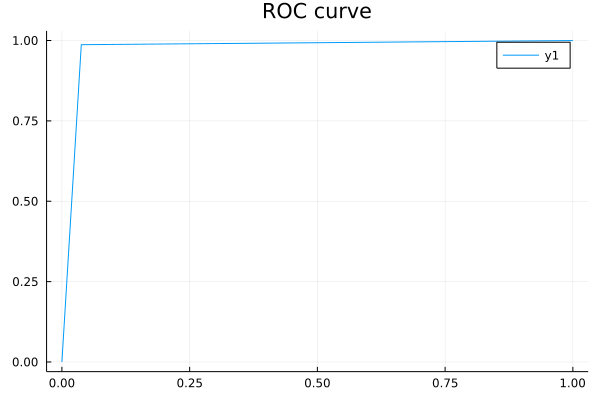

In [18]:
fpr, tpr, thresholds = sklearn.roc_curve(prediccion.Real, prediccion.Prediccion)
plot(fpr, tpr)
title!("ROC curve")

In [19]:
@printf "AUC: %.2f%%\n" auc * 100
@printf "Accuracy: %.2f%%\n" mean(prediction_class_test .== test[:, 61]) * 100

AUC: 97.45%
Accuracy: 97.44%


### Regresión lineal

El modelo de regresión lineal predice el valor de la etiqueta definido previamente. El modelo es realizado con todas las variables predictoras. Dado que este modelo puede predecir cualquier valor al tener como función de enlace la gaussiana, predice números continuos y que puedes estar por fuera del rango [0, 1]. 

Para medir el desempeño de este modelo, se asignará la etiqueta más cercana al número predicho por el modelo. Así, si el número está en el rango (-Inf, 0.5) se le asignará el valor 0, y en otro caso se asignará la etiqueta 1. 

In [20]:
linearRegressor = lm(fm, train)

# Prediction
ypredicted_test = GLM.predict(linearRegressor, test);


prediction_class_test = [if round(x) <= 0 0 elseif round(x) > 1 1 else round(x) end for x in ypredicted_test];

In [21]:
prediccion = [Int.(test.x61) Int.(prediction_class_test)]
prediccion = DataFrame(prediccion, [:Real, :Prediccion]);

In [22]:
cm = MLBase.roc(prediccion.Real, prediccion.Prediccion)

ROCNums{Int64}
  p = 77
  n = 79
  tp = 69
  tn = 58
  fp = 21
  fn = 8


In [23]:
sens = 69/(69+8);
espe = 58/(58+21);
auc = (sens + espe)/2;

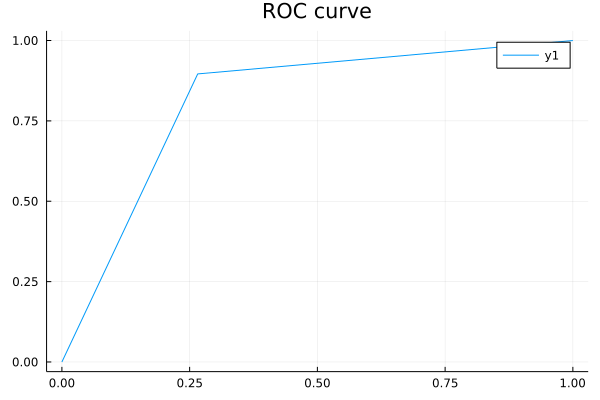

In [24]:
fpr, tpr, thresholds = sklearn.roc_curve(prediccion.Real, prediccion.Prediccion)
plot(fpr, tpr)
title!("ROC curve")

In [25]:
@printf "AUC: %.2f%%\n" auc * 100
@printf "Accuracy: %.2f%%\n" mean(prediction_class_test .== test[:, 61]) * 100

AUC: 81.51%
Accuracy: 81.41%


### SVM

Este modelo realiza la clasificación de la etiqueta encontrando el hiperplano que maximiza la separación entre grupos minimizando la distancia entre sus puntos. Para encontrar este hiperplano se utilizan todas las variables independientes.

In [26]:
y_train = ifelse.(train[:, 61] .== 1, "R", "M");

In [27]:
x_train = Array(train[:, 1:60])';

In [28]:
x_test = Array(test[:, 1:60])';
y_test = ifelse.(test[:, 61] .== 1, "R", "M");

In [29]:
model = LIBSVM.svmtrain(x_train, y_train)

pred, decision_values = LIBSVM.svmpredict(model, x_test);

In [30]:
prediccion = [Int.(test[:, 61]) [if y == "R" 1 else 0 end for y in pred]]
prediccion = DataFrame(prediccion, [:Real, :Prediccion]);

In [31]:
cm = MLBase.roc(prediccion.Real, prediccion.Prediccion)

ROCNums{Int64}
  p = 77
  n = 79
  tp = 60
  tn = 65
  fp = 14
  fn = 17


In [32]:
sens = 60/(60+17);
espe = 65/(65+14);
auc = (sens + espe)/2;

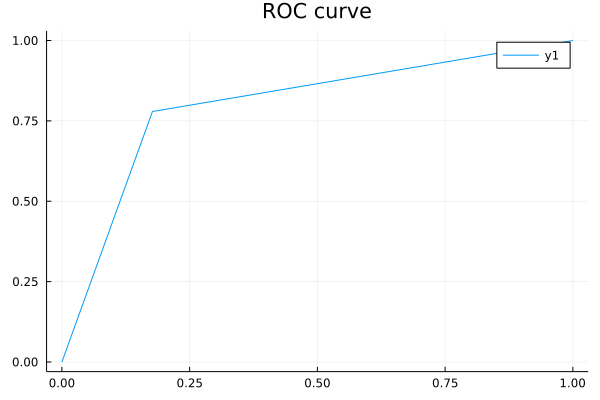

In [33]:
fpr, tpr, thresholds = sklearn.roc_curve(prediccion.Real, prediccion.Prediccion)
plot(fpr, tpr)
title!("ROC curve")

In [34]:
@printf "AUC: %.2f%%\n" auc * 100
@printf "Accuracy: %.2f%%\n" mean(pred .== y_test) * 100

AUC: 80.10%
Accuracy: 80.13%


### Árbol de decisión

El árbol de decisión realiza particiones recursivas determinando un punto de corte para cada variable que evalúa hasta alcanzar un nivel de profundidad del árbol. En este caso, se realizarán máximo 15 particiones. 

In [35]:
x_train = Array(train[:, 1:60]);
x_test = Array(test[:, 1:60]);

In [36]:
model = DecisionTreeClassifier(max_depth=15)
DecisionTree.fit!(model, x_train, y_train)

DecisionTreeClassifier
max_depth:                15
min_samples_leaf:         1
min_samples_split:        2
min_purity_increase:      0.0
pruning_purity_threshold: 1.0
n_subfeatures:            0
classes:                  ["M", "R"]
root:                     Decision Tree
Leaves: 20
Depth:  8

In [37]:
pred = DecisionTree.predict(model, x_test);

In [38]:
prediccion = [Int.(test[:, 61]) [if y == "R" 1 else 0 end for y in pred]]
prediccion = DataFrame(prediccion, [:Real, :Prediccion]);

In [39]:
cm = MLBase.roc(prediccion.Real, prediccion.Prediccion)

ROCNums{Int64}
  p = 77
  n = 79
  tp = 71
  tn = 76
  fp = 3
  fn = 6


In [40]:
sens = 71/(71+6);
espe = 76/(76+3);
auc = (sens + espe)/2;

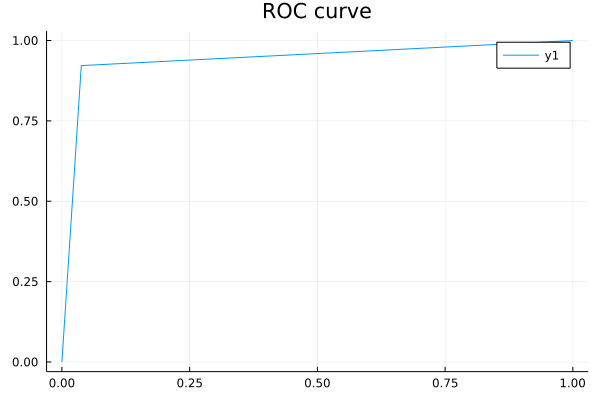

In [41]:
fpr, tpr, thresholds = sklearn.roc_curve(prediccion.Real, prediccion.Prediccion)
plot(fpr, tpr)
title!("ROC curve")

In [42]:
@printf "AUC: %.2f%%\n" auc * 100
@printf "Accuracy: %.2f%%\n" mean(pred .== y_test) * 100

AUC: 94.21%
Accuracy: 94.23%


### KNN

Este algoritmo clasifica un elemento con base en la etiqueta predominante entre los K elementos más cercanos a este. Se calculan las distancias del elemento nuevo con respecto a los elementos existentes y se asigna la etiqueta con base en los elementos que tengan las menores distancias. En este caso se usa la distancia euclidiana y K = 5. 

In [43]:
train2 = [x_train y_train];
train2 = DataFrame(train2);

In [44]:
@sk_import neighbors: KNeighborsClassifier
model = KNeighborsClassifier()

PyObject KNeighborsClassifier()

In [45]:
ScikitLearn.fit!(model, x_train, y_train)

PyObject KNeighborsClassifier()

In [46]:
pred_test = ScikitLearn.predict(model, x_test);

In [47]:
prediccion = [Int.(test[:, 61]) [if y == "R" 1 else 0 end for y in pred_test]]
prediccion = DataFrame(prediccion, [:Real, :Prediccion]);

In [48]:
cm = MLBase.roc(prediccion.Real, prediccion.Prediccion)

ROCNums{Int64}
  p = 77
  n = 79
  tp = 72
  tn = 64
  fp = 15
  fn = 5


In [49]:
sens = 72/(72+5);
espe = 64/(64+15);
auc = (sens + espe)/2;

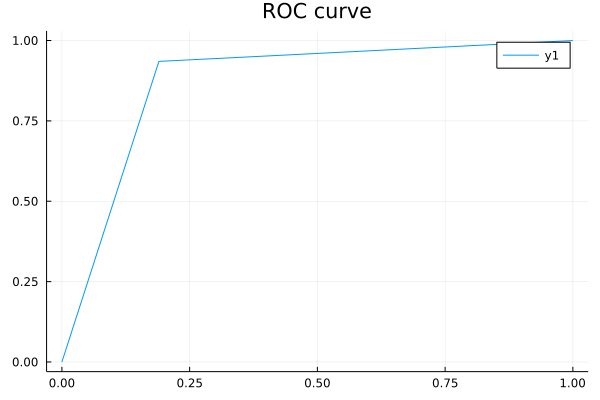

In [50]:
fpr, tpr, thresholds = sklearn.roc_curve(prediccion.Real, prediccion.Prediccion)
plot(fpr, tpr)
title!("ROC curve")

In [51]:
@printf "AUC: %.2f%%\n" auc * 100
@printf "Accuracy: %.2f%%\n" mean(pred_test .== y_test) * 100

AUC: 87.26%
Accuracy: 87.18%


## Mejor modelo

A continuación se presentan las medidas de desempeño sobre la base de prueba para todos los modelos:

| Modelo              | Accuracy | AUC    |
|---------------------|----------|--------|
| Regresión Logística | 97.44%   | 97.45% |
| Regresión Lineal    | 81.41%   | 81.51% |
| SVM                 | 80.13%   | 80.10% |
| Árbol de decisión   | 94.23%   | 94.21% |
| KNN                 | 87.18%   | 87.26% |

Con base en lo anterior, el modelo que realiza la clasificación más precisa es la regresión logística, la cual tiene una precisión del 97.44% y un AUC de 97.45%, lo que indica que realiza una clasificación casi perfecta de las rocas y las minas. Además, este modelo consiguió una clasificación mayor a lo conseguido con los modelos anteriores. En segundo lugar, el árbol de decisión tuvo una precisión de 94.23% y un AUC del 94.21%. 